In [78]:
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

# 数据集载入
train_data = datasets.MNIST(root = "./data/",transform=transform,train = True,download = True)
test_data = datasets.MNIST(root="./data/",transform = transform,train = False)
print('训练集/测试集:',len(train_data),'/',len(test_data))

#加载器
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True,num_workers=2)
print('训练batch/测试batch:',len(train_loader),'/',len(test_loader))
data_iter = iter(train_loader)

训练集/测试集: 60000 / 10000
训练batch/测试batch: 938 / 157


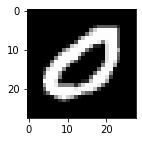

tensor(0)


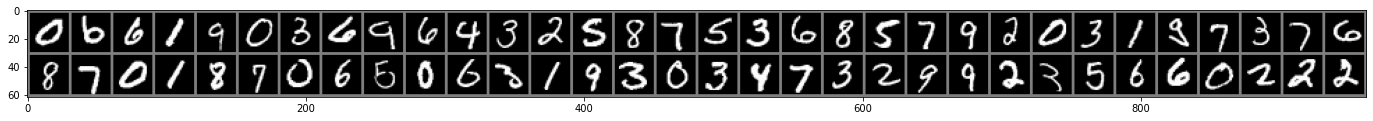

0 6 6 1 9 0 3 6 9 6 4 3 2 5 8 7 5 3 6 8 5 7 9 2 0 3 1 9 7 3 7 6 
8 7 0 1 8 7 0 6 5 0 6 3 1 9 3 0 3 4 7 3 2 9 9 2 3 5 6 6 0 2 2 2 


In [100]:
nd = next(data_iter)
oneimg,label = nd[0][0],nd[1][0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.figure(figsize=(2,2))
plt.imshow(grid)
plt.show()
print(label)

images, lables =nd
plt.figure(figsize=(24,12))
img = utils.make_grid(images,32)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
plt.imshow(img)
plt.show()
for i in range(64):
    print(int(lables[i]), end=" ")
    i += 1
    if i%32 == 0:
        print(end='\n')

In [160]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        
        
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
#         x = self.fc3(x)
#         self.dp(x)
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x
net = CNN()


import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(),lr=0.005)#Adam优化方法比较时髦


In [161]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('%d,%5d\tL:%.3f' % (epoch+1,i+1,running_loss/100), end='|')
            running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)

print('[END]')

torch.cuda.empty_cache()

1,  100	L:2.295|1,  200	L:2.274|1,  300	L:2.233|1,  400	L:2.128|1,  500	L:1.734|1,  600	L:0.964|1,  700	L:0.569|1,  800	L:0.431|1,  900	L:0.356|2,  100	L:0.308|2,  200	L:0.284|2,  300	L:0.247|2,  400	L:0.232|2,  500	L:0.223|2,  600	L:0.223|2,  700	L:0.210|2,  800	L:0.180|2,  900	L:0.180|3,  100	L:0.169|3,  200	L:0.152|3,  300	L:0.147|3,  400	L:0.141|3,  500	L:0.137|3,  600	L:0.138|3,  700	L:0.133|3,  800	L:0.126|3,  900	L:0.137|[END]


c:\python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


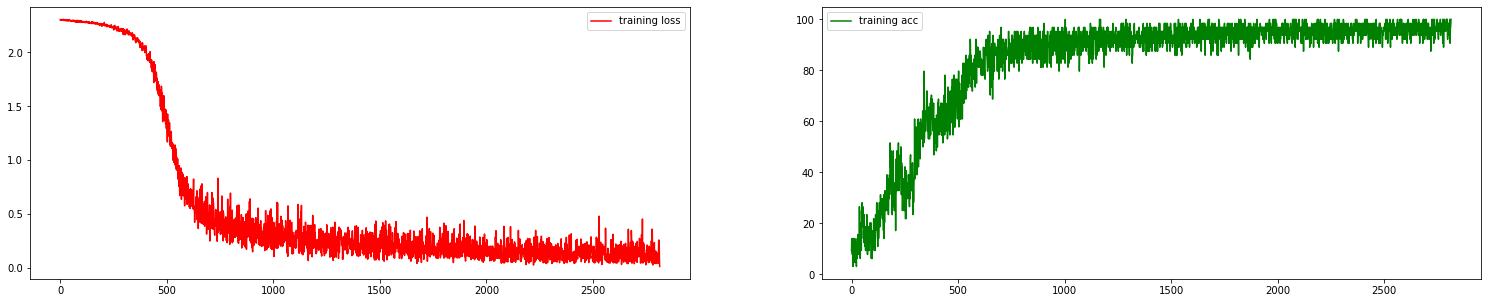

In [162]:
import seaborn as sns
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    fig, axes = plt.subplots(1, 2, figsize=[26, 5])
    sns.lineplot(iters, costs,color='red',label=label_cost, ax = axes[0]) 
    sns.lineplot(iters, accs,color='green',label=lable_acc,ax=axes[1]) 
    plt.show()
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

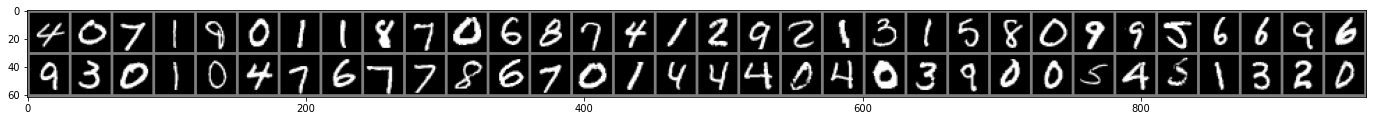

REAL:  4 0 7 1 9 0 1 1 8 7 0 6 8 7 4 1 2 9 2 1 3 1 5 8 0 9 9 5 6 6 9 6 9 3 0 1 0 4 7 6 7 7 8 6 7 0 1 4 4 4 0 4 0 3 9 0 0 5 4 5 1 3 2 0
GUES:  4 0 7 1 9 0 1 1 8 7 0 6 8 7 4 1 2 9 2 1 3 1 5 8 0 9 9 5 6 6 9 6 9 3 0 1 0 4 7 6 7 7 8 6 7 0 1 4 4 4 0 4 0 3 9 0 0 5 4 5 1 3 2 0
  -   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [163]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
plt.figure(figsize=(24,12))
test_img = utils.make_grid(images,32)
test_img = test_img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()
print('REAL: ', ' '.join('%d' % labels[j] for j in range(64)))

# test_net = CNN()
# test_net.load_state_dict(torch.load(PATH))
test_out = net(images.cuda())
_, predicted = torch.max(test_out, dim=1)

print('GUES: ', ' '.join('%d' % predicted[j]
                              for j in range(64)))
x=  predicted.cpu()-labels
print('  -  ',' '.join('%d'%i for i in x ))